#  <center> Speech Emotion Recognition (SER Superset) <center>
##  <center>     (Without Cross Validation) <center>

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

# Modeling related packages
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1) Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [2]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [3]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df['Actor'] = Ravdess_df['Path'].str.split('-').str[-1].str.split('.').str[0]
Ravdess_df['Gender'] = np.where(Ravdess_df['Actor'].astype(int) % 2 == 1, 'Male', 'Female')

pd.set_option('display.max_colwidth', None)
Ravdess_df.head()

,Emotions,Path,Actor,Gender
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav,02,Female
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav,02,Female
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-07-02-01-02-02.wav,02,Female
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-07-01-01-02-02.wav,02,Female
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-01-01-02-01-02.wav,02,Female


## <center>2. Crema DataFrame</center>

In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_gender = pd.read_csv("/kaggle/input/crema-actor-gender/actor-genderid - actor-genderid.csv")
crema_gender = crema_gender.rename(columns={'Sex': 'Gender'})
crema_gender = crema_gender.drop(['Age','Race','Ethnicity'],axis =1)
crema_gender.head()

,ActorID,Gender
0,1001,Male
1,1002,Female
2,1003,Female
3,1004,Female
4,1005,Male


In [5]:
Crema_df['match_actorID'] = Crema_df['Path'].str.extract(r'(\d+)')
crema_gender['match_actorID'] = crema_gender['ActorID'].astype(str)

# Perform the merge based on the common value
merged_df_crema = pd.merge(Crema_df, crema_gender, on='match_actorID',how = 'left')

merged_df_crema  = merged_df_crema .drop(['match_actorID'],axis =1)
merged_df_crema  = merged_df_crema .rename(columns={'Gender_y': 'Gender'})
merged_df_crema  = merged_df_crema.rename(columns={'ActorID': 'Actor'})

In [6]:
actor_list = list(merged_df_crema['Actor'].unique())
actor_list.sort()
actor_dict = {}
corrected_actor_id = list(range(31,122))
for i in range(len(actor_list)):
    actor_dict[actor_list[i]] = corrected_actor_id[i]
merged_df_crema['Actor'] = merged_df_crema['Actor'].replace(actor_dict)
merged_df_crema.head()

,Emotions,Path,Actor,Gender
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav,58,Female
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav,105,Female
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav,114,Female
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav,97,Male
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav,96,Male


##  <center> 3. TESS dataset <center>

In [7]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df['Gender'] = 'Female'
pd.set_option('display.max_colwidth', None)
Tess_df['Actor'] = Tess_df['Path'].str.extract(r'/(OAF|YAF)_')

# Map the extracted values to the corresponding actor numbers
actor_mapping = {'OAF': '25', 'YAF': '26'}
Tess_df['Actor'] = Tess_df['Actor'].map(actor_mapping)
Tess_df.head()

,Emotions,Path,Gender,Actor
0,fear,/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav,Female,26
1,fear,/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav,Female,26
2,fear,/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav,Female,26
3,fear,/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav,Female,26
4,fear,/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav,Female,26


##  <center> 4. SAVEE dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [8]:
savee_directory_list = os.listdir(Savee)
file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df['Gender'] = 'Male'
Savee_df['Actor'] = Savee_df['Path'].str.extract(r'/(DC|JE|JK|KL)_')

# Map the extracted values to the corresponding actor numbers
actor_mapping = {'DC': '27', 'JE': '28', 'JK': '29', 'KL': '30'}
Savee_df['Actor'] = Savee_df['Actor'].map(actor_mapping)
Savee_df.head()

,Emotions,Path,Gender,Actor
0,happy,/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/JE_h09.wav,Male,28
1,fear,/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/KL_f12.wav,Male,30
2,happy,/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_h03.wav,Male,27
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_d04.wav,Male,27
4,angry,/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/KL_a14.wav,Male,30


In [9]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, merged_df_crema, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path,Actor,Gender
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav,02,Female
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav,02,Female
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-07-02-01-02-02.wav,02,Female
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-07-01-01-02-02.wav,02,Female
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-01-01-02-01-02.wav,02,Female


In [16]:
import re
import pandas as pd

# Define the regular expression patterns
pattern1 = r'ravdess-emotional-speech-audio'
pattern2 = r'cremad'
pattern3 = r'toronto-emotional-speech-set-tess'
pattern4 = r'surrey-audiovisual-expressed-emotion-savee'

# Create a new column based on the conditions
data_path['Dataset'] = data_path['Path'].apply(lambda x: re.search(pattern1, x).group(0) if re.search(pattern1, x)
                                     else re.search(pattern2, x).group(0) if re.search(pattern2, x)
                                     else re.search(pattern3, x).group(0) if re.search(pattern3, x)
                                     else re.search(pattern4, x).group(0) if re.search(pattern4, x)
                                     else 'No Match')

### Combining data to a single dataframe

- Remove class Imbalance
- Segregating a portion of data to avoid data leakage

In [17]:
# Removing classes with very less emotions captured
data_path_rem=data_path[(data_path['Emotions']!='surprise')&(data_path['Emotions']!='calm')]
data_path_rem['Actor'] = data_path_rem['Actor'].astype(int)

In [20]:
# Segregating a portion of data to avoid data leakage
data_path=data_path_rem[(data_path_rem['Dataset']=='ravdess-emotional-speech-audio')|(~data_path_rem['Actor'].isin([1,2,3,4]))]
data_path_test=data_path_rem[(data_path_rem['Dataset']=='ravdess-emotional-speech-audio')&(data_path_rem['Actor'].isin([1,2,3,4]))]

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating

In [14]:
rate=0.8
sampling_rate=22050
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=2.0)

def pitch(data):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=10)

import scipy.signal as signal

def low_pass_filter(data):
    # Define the filter parameters
    nyquist_freq = 0.5 * sampling_rate
    cutoff_freq = 5000  # Set the cutoff frequency of the filter to 5 kHz
    numtaps = 10        # Set the number of filter taps (length of the filter)

    # Create a low-pass filter with the specified parameters
    taps = signal.firwin(numtaps, cutoff_freq/nyquist_freq)

    # Apply the filter to the audio signal
    filtered_audio = signal.convolve(data, taps, mode='same')

    return filtered_audio

## Feature Extraction - Statistical and accoustic 
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


The acoustic features extracted are:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

The statistical features that are extracted are:
- Mean
- Variance
- Skewness
- Kurtosis
- Audio_rms
- Spectral centroids
- Spectral bandwidth

In [15]:
sample_rate=22050
import os, glob
import librosa
import numpy as np
import scipy
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def statistical_features(data):
    result = np.array([])
    mean = np.mean(data)#
    result=np.hstack((result, mean)) # stacking horizontally
    
    variance = np.var(data)#
    result=np.hstack((result, variance)) # stacking horizontally
    
    skewness = scipy.stats.skew(data)#
    result=np.hstack((result, skewness)) # stacking horizontally
    
    kurtosis = scipy.stats.kurtosis(data)#
    result=np.hstack((result, kurtosis)) # stacking horizontally
    
    audio_rms = librosa.feature.rms(y=data)
    audio_rms_mean = audio_rms.mean()#
    result=np.hstack((result, audio_rms_mean)) # stacking horizontally
    
    spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sampling_rate)[0]#
    result=np.hstack((result, spectral_centroids.mean())) # stacking horizontally
    
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sampling_rate)[0]#
    result=np.hstack((result, spectral_bandwidth.mean())) # stacking horizontally
    
    mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
    mfcc = mfccs.mean()#
    result=np.hstack((result, mfcc)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    stat=statistical_features(data)
    result=np.hstack((result,stat))
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    stat2=statistical_features(noise_data)
    result2=np.hstack((res2,stat2))
    result1 = np.vstack((result, result2)) # stacking vertically
    
    # data with stretch
    stretched_data = stretch(data)
    res3 = extract_features(stretched_data)
    stat3=statistical_features(stretched_data)
    result2=np.hstack((res3,stat3))
    
    # data with LPF
    low_pass_filter_data = low_pass_filter(data)
    res4 = extract_features(low_pass_filter_data)
    stat4=statistical_features(low_pass_filter_data)
    result3=np.hstack((res4,stat4))
    
    # data with pitch
    pitch_data = pitch(data)
    res5 = extract_features(pitch_data)
    stat5=statistical_features(pitch_data)
    result4=np.hstack((res5,stat5))

    result = np.vstack((result, result2,result3,result4)) # stacking vertically
    return result


## Creating a sequence of features and target

In [126]:
X, Y,gender_list = [], [],[]
for path, emotion, gender in zip(data_path.Path, data_path.Emotions,data_path.Gender):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
        gender_list.append(gender)

# The same process is repeated for the test data that is segregated
X_new, Y_new,gender_list_new = [], [],[]
for path, emotion, gender in zip(data_path_test.Path, data_path_test.Emotions,data_path_test.Gender):
    feature = get_features(path)
    for ele in feature:
        X_new.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y_new.append(emotion)
        gender_list_new.append(gender)

In [ ]:
# For the train and validation set
gender=[]
for i in gender_list:
    if i=='Male':
        gender.append(1)
    else:
        gender.append(0)
# For the test set
gender_new=[]
for i in gender_list_new:
    if i=='Male':
        gender_new.append(1)
    else:
        gender_new.append(0)

##  Feature selection
- Creating required features to assess only deep features as well as concatenation of deep, statistic and gender features

In [133]:
X_df=pd.DataFrame(X)
X=np.array(X)

X_stat=X[:,161:169]
X=X[:,:161]

# Statistic features saved
# np.save('All_Aug_Statistic.npy',np.array(X_stat))

# load the .npy file
# X_stat = np.load('All_Aug_Statistic.npy')

Features = pd.DataFrame(X)
Features['labels'] = Y

# Combining both statistic and deep features and gender to create a common dataframe
stat_col_index=len(Features.columns)
stat_features=8
X_stat_df = pd.DataFrame(X_stat,columns=list(range(stat_col_index,stat_col_index+stat_features)))

gender_col_index=len(Features.columns)+stat_features
X_gender_df=pd.DataFrame(gender,columns=list(range(gender_col_index,gender_col_index+1)))

# stacking horizontally for getting all combinations
X_ac_stat_nogen = pd.concat([Features, X_stat_df], axis=1)

X_ac_stat = pd.concat([Features, X_stat_df,X_gender_df], axis=1)

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [140]:
# To ensure reproduceability
import tensorflow as tf
np.random.seed(123)
tf.random.set_seed(123)

# Setting feature and target 
X = X_ac_stat.drop('labels',axis=1).values
Y = X_ac_stat['labels'].values

# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True,stratify=Y)

# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# Acoustic feature segregation for deep feature extraction
x_train_ac = x_train[:, :162]
x_test_ac=x_test[:, :162]

x_train_stat = x_train[:, 162:170]
x_test_stat=x_test[:, 162:170]

x_train_gen=x_train[:,-1]
x_test_gen=x_test[:,-1]

## Deep Feature Extraction

In [151]:
num_classes=6
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train_ac.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=12, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 41, 256)           0         
                                                                 
 flatten_2 (Flatten)         (None, 10496)            

#### Experimental Setting
Setting the below:
- Model to take best weights
- Early stop on validation loss, patience of 8
- Reduce Learning rate on Plateau

##### Further fitting the conv1d model to extract deep features from acoustic features

In [153]:
checkpoint = ModelCheckpoint(filepath='deep_features_best_weights.h5', save_best_only=True)
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=8)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=6, min_lr=0.0000001)
callback_list=[checkpoint,rlrp,early_stopping_callback]

model.fit(x_train_ac, y_train, batch_size=128, epochs=200, validation_data=(x_test_ac, y_test), callbacks=callback_list)

Epoch 1/200
266/266 [==============================] - 108s 399ms/step - loss: 1.6008 - accuracy: 0.3070 - precision_2: 0.6573 - recall_2: 0.0555 - val_loss: 1.4344 - val_accuracy: 0.4166 - val_precision_2: 0.8471 - val_recall_2: 0.1126 - lr: 0.0010
Epoch 2/200
266/266 [==============================] - 105s 394ms/step - loss: 1.4578 - accuracy: 0.3912 - precision_2: 0.7187 - recall_2: 0.1296 - val_loss: 1.3348 - val_accuracy: 0.4587 - val_precision_2: 0.7814 - val_recall_2: 0.1996 - lr: 0.0010
Epoch 3/200
266/266 [==============================] - 104s 389ms/step - loss: 1.3824 - accuracy: 0.4302 - precision_2: 0.7459 - recall_2: 0.1802 - val_loss: 1.2671 - val_accuracy: 0.5013 - val_precision_2: 0.8593 - val_recall_2: 0.2213 - lr: 0.0010
Epoch 4/200
266/266 [==============================] - 108s 407ms/step - loss: 1.3309 - accuracy: 0.4539 - precision_2: 0.7558 - recall_2: 0.2135 - val_loss: 1.2253 - val_accuracy: 0.5118 - val_precision_2: 0.8653 - val_recall_2: 0.2502 - lr: 0.0010


In [154]:
# Base to check feature extractor accuracy
print("Accuracy of our model on test data : " , model.evaluate(x_test_ac,y_test)[1]*100 , "%")

354/354 [==============================] - 7s 21ms/step - loss: 1.0329 - accuracy: 0.6079 - precision_2: 0.8008 - recall_2: 0.4393
Accuracy of our model on test data :  60.788124799728394 %


In [155]:
# Extracting deep features
from tensorflow.keras.models import Model

conv1d_feature_model=Model(inputs=model.input,outputs=model.layers[-5].output)
conv1d_features=conv1d_feature_model.predict(x_train_ac)
conv1d_features_test=conv1d_feature_model.predict(x_test_ac)

354/354 [==============================] - 7s 20ms/step


## Concatenate statistical and gender features 

In [158]:
# Getting back old shape of xtrain and xtest
x_train_stat = np.squeeze(x_train_stat)
x_test_stat = np.squeeze(x_test_stat)
# x_train_gen = np.squeeze(x_train_gen)
x_train_concat=np.concatenate((conv1d_features,x_train_stat,x_train_gen),axis=1)

## Fitting a deep learning classifier model

### Just based on deep features

In [159]:
model_classify_deep = Sequential()
model_classify_deep.add(Dense(12, input_shape=(32,), activation='relu'))
model_classify_deep.add(Dense(10, activation='relu'))
model_classify_deep.add(Dense(num_classes, activation='softmax'))
model_classify_deep.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [160]:
history_deep=model_classify_deep.fit(conv1d_features,y_train,validation_split=0.2,epochs=200, callbacks=callback_list)

Epoch 1/200
849/849 [==============================] - 3s 3ms/step - loss: 1.0518 - accuracy: 0.6038 - precision_3: 0.8822 - recall_3: 0.3811 - val_loss: 0.7939 - val_accuracy: 0.6905 - val_precision_3: 0.8449 - val_recall_3: 0.5575 - lr: 0.0010
Epoch 2/200
849/849 [==============================] - 3s 3ms/step - loss: 0.7744 - accuracy: 0.6985 - precision_3: 0.8398 - recall_3: 0.5693 - val_loss: 0.7716 - val_accuracy: 0.6947 - val_precision_3: 0.8450 - val_recall_3: 0.5644 - lr: 0.0010
Epoch 3/200
849/849 [==============================] - 2s 3ms/step - loss: 0.7648 - accuracy: 0.6982 - precision_3: 0.8390 - recall_3: 0.5739 - val_loss: 0.7696 - val_accuracy: 0.6967 - val_precision_3: 0.8454 - val_recall_3: 0.5678 - lr: 0.0010
Epoch 4/200
849/849 [==============================] - 2s 2ms/step - loss: 0.7615 - accuracy: 0.7001 - precision_3: 0.8395 - recall_3: 0.5766 - val_loss: 0.7684 - val_accuracy: 0.6962 - val_precision_3: 0.8505 - val_recall_3: 0.5612 - lr: 0.0010
Epoch 5/200
849/

In [161]:
model_classify_deep.evaluate(conv1d_features_test,y_test)

354/354 [==============================] - 1s 2ms/step - loss: 1.0925 - accuracy: 0.6120 - precision_3: 0.7389 - recall_3: 0.4988


[1.092477798461914, 0.6120339035987854, 0.7388743162155151, 0.4987630248069763]

### Based on statistical and deep features on deep learning classifier

In [163]:
stat_deep=np.concatenate((conv1d_features,x_train_stat,x_train_gen),axis=1)
stat_deep_test=np.concatenate((conv1d_features_test,x_test_stat,x_test_gen),axis=1)

### MLP - Dense Network Classifier

In [164]:
model_classify = Sequential()
model_classify.add(Dense(12, input_shape=(stat_deep.shape[1],), activation='relu'))
model_classify.add(Dense(10, activation='relu'))
model_classify.add(Dense(num_classes, activation='softmax'))
model_classify.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [165]:
model_classify.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 12)                504       
                                                                 
 dense_13 (Dense)            (None, 10)                130       
                                                                 
 dense_14 (Dense)            (None, 6)                 66        
                                                                 
Total params: 700
Trainable params: 700
Non-trainable params: 0
_________________________________________________________________


In [166]:
history_classify=model_classify.fit(stat_deep,y_train,validation_split=0.2,epochs=50,callbacks=callback_list,batch_size=64)

Epoch 1/50
425/425 [==============================] - 2s 3ms/step - loss: 1.2305 - accuracy: 0.5537 - precision_4: 0.8421 - recall_4: 0.2990 - val_loss: 0.8543 - val_accuracy: 0.6788 - val_precision_4: 0.8858 - val_recall_4: 0.4898 - lr: 0.0010
Epoch 2/50
425/425 [==============================] - 1s 2ms/step - loss: 0.8075 - accuracy: 0.6895 - precision_4: 0.8561 - recall_4: 0.5390 - val_loss: 0.7920 - val_accuracy: 0.6939 - val_precision_4: 0.8477 - val_recall_4: 0.5600 - lr: 0.0010
Epoch 3/50
425/425 [==============================] - 1s 3ms/step - loss: 0.7778 - accuracy: 0.6976 - precision_4: 0.8395 - recall_4: 0.5720 - val_loss: 0.7772 - val_accuracy: 0.6970 - val_precision_4: 0.8434 - val_recall_4: 0.5733 - lr: 0.0010
Epoch 4/50
425/425 [==============================] - 1s 3ms/step - loss: 0.7674 - accuracy: 0.7001 - precision_4: 0.8373 - recall_4: 0.5799 - val_loss: 0.7731 - val_accuracy: 0.6978 - val_precision_4: 0.8495 - val_recall_4: 0.5687 - lr: 0.0010
Epoch 5/50
425/425 [

## Evaluating on validation data

In [168]:
model_classify.evaluate(stat_deep_test,y_test)

354/354 [==============================] - 1s 2ms/step - loss: 1.1031 - accuracy: 0.6112 - precision_4: 0.7378 - recall_4: 0.4949


[1.1031278371810913, 0.6112387180328369, 0.7378474473953247, 0.494875431060791]

## Test Prediction

In [169]:
X_new=np.array(pd.DataFrame(X_new))
X_stat_new=X_new[:,161:169]
X_ac_new=X_new[:,:161]

Y_new_encoded=encoder.fit_transform(np.array(Y_new).reshape(-1,1)).toarray()
    
# Array conversion
X_ac_new=np.array(X_ac_new)
X_stat_new=np.array(X_stat_new)
gender_new=np.array(gender_new)
Y_new_encoded=np.array(Y_new_encoded)

# New
# concatenate
# X_ac_new,
gender_new1 = np.expand_dims(gender_new, axis=1)
x_new=np.concatenate((X_ac_new,X_stat_new,gender_new1),axis=1)

# Acoustic feature segregation for deep feature extraction
x_new_deep = x_new[:, :162]
x_new_stat=x_new[:, 162:170]
x_new_gen=x_new[:,-1]
x_new_gen = np.expand_dims(x_new_gen, axis=1)

# Normalization
x_new = scaler.transform(x_new)
x_new.shape

# Acoustic feature segregation for deep feature extraction
x_new_deep = x_new[:, :162]
x_new_stat=x_new[:, 162:170]
x_new_gen=x_new[:,-1]
x_new_gen = np.expand_dims(x_new_gen, axis=1)

# For compatibility with model
x_new=np.expand_dims(x_new, axis=2)
x_new_deep=np.expand_dims(x_new_deep, axis=2)
x_new_stat=np.expand_dims(x_new_stat, axis=2)

In [173]:
conv1d_features_new=conv1d_feature_model.predict(x_new_deep)

22/22 [==============================] - 0s 21ms/step


In [174]:
model_classify_deep.evaluate(conv1d_features_new,Y_new_encoded)

22/22 [==============================] - 0s 2ms/step - loss: 0.9575 - accuracy: 0.6719 - precision_3: 0.8158 - recall_3: 0.4844


[0.9575027227401733, 0.671875, 0.8157894611358643, 0.484375]

In [175]:
conv1d_features_new=np.squeeze(conv1d_features_new)
x_new_stat=np.squeeze(x_new_stat)
x_new_concat=np.concatenate((conv1d_features_new,x_new_stat,x_new_gen),axis=1)

In [176]:
model_classify.evaluate(x_new_concat,Y_new_encoded)

22/22 [==============================] - 0s 2ms/step - loss: 0.9286 - accuracy: 0.6804 - precision_4: 0.8145 - recall_4: 0.5114


[0.9286327362060547, 0.6803977489471436, 0.814479649066925, 0.5113636255264282]

ValueError: x and y must have same first dimension, but have shapes (50,) and (43,)

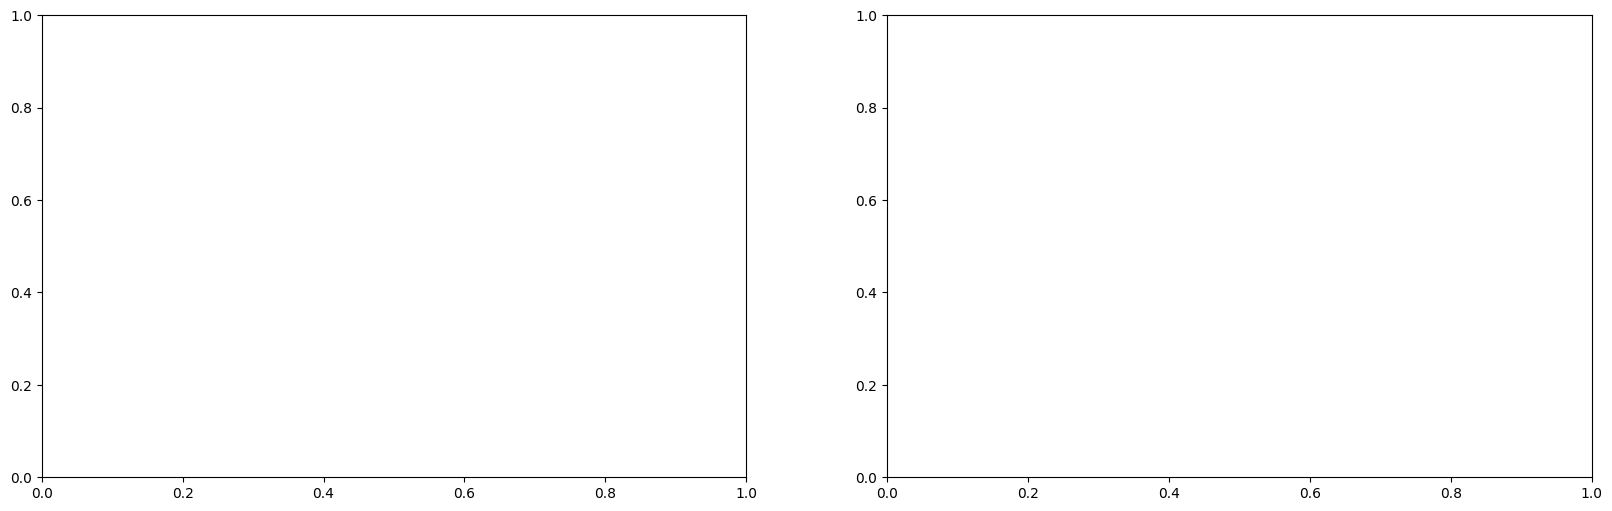

In [177]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history_classify.history['accuracy']
train_loss = history_classify.history['loss']
test_acc = history_classify.history['val_accuracy']
test_loss = history_classify.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history_classify.history['precision_4']
train_loss = history_classify.history['loss']
test_acc = history_classify.history['val_precision_4']
test_loss = history_classify.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Precision')
ax[1].plot(epochs , test_acc , label = 'Testing Precision')
ax[1].set_title('Training & Testing Precision')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

### Making predictions

In [ ]:
pred=model_classify.predict(stat_deep_test)

In [ ]:
len(stat_deep_test),len(y_test)

In [ ]:
# model_classify.evaluate(stat_deep_test,y_test)

In [ ]:
model_classify.input

In [ ]:
# Saving the model weights
model_classify.save('ser_fusionnet.h5')

In [ ]:
from tensorflow.keras.models import load_model

chk_model=load_model('ser_fusionnet.h5')

In [ ]:
# predicting on test data.
pred_test = model_classify.predict(stat_deep_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
# predicting on test data.
pred_test = model_classify.predict(x_new_concat)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(Y_new_encoded)


In [ ]:

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

### Real Time

In [150]:
# !apt-get install -y portaudio19-dev
# !pip install pyaudio

In [ ]:
# history_classify=model_classify.fit(stat_deep,y_train,validation_split=0.2,epochs=50,callbacks=callback_list,batch_size=64)

In [172]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

# Define the model
model_classify = Sequential()
model_classify.add(Dense(12, input_shape=(stat_deep.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_classify.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_classify.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_classify.compile(
                       loss='categorical_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model
history = model_classify.fit(stat_deep, y_train,
                             validation_split=0.1,
                             epochs=50,
                             batch_size=32)

# Save the model
model_classify.save('ser_fusionnet.h5')

# Load the saved model
chk = load_model('ser_fusionnet.h5')

# Use the loaded model for predictions or further training

Epoch 1/50

75/75 [==============================] - 1s 6ms/step - loss: 1.7305 - accuracy: 0.3649 - precision_12: 0.8646 - recall_12: 0.1263 - val_loss: 1.4896 - val_accuracy: 0.4811 - val_precision_12: 0.9444 - val_recall_12: 0.2576

Epoch 2/50

75/75 [==============================] - 0s 2ms/step - loss: 1.3180 - accuracy: 0.5964 - precision_12: 0.9654 - recall_12: 0.3287 - val_loss: 1.2051 - val_accuracy: 0.6250 - val_precision_12: 0.9279 - val_recall_12: 0.3902

Epoch 3/50

75/75 [==============================] - 0s 3ms/step - loss: 1.0331 - accuracy: 0.7790 - precision_12: 0.9730 - recall_12: 0.4705 - val_loss: 0.9336 - val_accuracy: 0.8068 - val_precision_12: 0.9730 - val_recall_12: 0.5455

Epoch 4/50

75/75 [==============================] - 0s 2ms/step - loss: 0.8055 - accuracy: 0.8485 - precision_12: 0.9684 - recall_12: 0.6056 - val_loss: 0.7267 - val_accuracy: 0.8561 - val_precision_12: 0.9716 - val_recall_12: 0.6477

Epoch 5/50

75/75 [==============================] - 0s 

In [153]:
import pyaudio

In [155]:
import pyaudio
import wave

# Set parameters for audio recording
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output.wav"

# Create an instance of PyAudio
audio = pyaudio.PyAudio()

# Open the audio stream for recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)

print("Recording...")

# Initialize an empty list to store the audio frames
frames = []

# Record audio in chunks and append to frames list
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("Finished recording.")

# Stop and close the audio stream
stream.stop_stream()
stream.close()
audio.terminate()

# Write the recorded audio to a WAV file
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()

In [183]:
Happy_Revathi = '/kaggle/input/our-audio/Happy_Revathi.wav'

In [78]:
import matplotlib.pyplot as plt

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(data)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [185]:
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
path

'/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_17/03-01-03-02-02-01-17.wav'

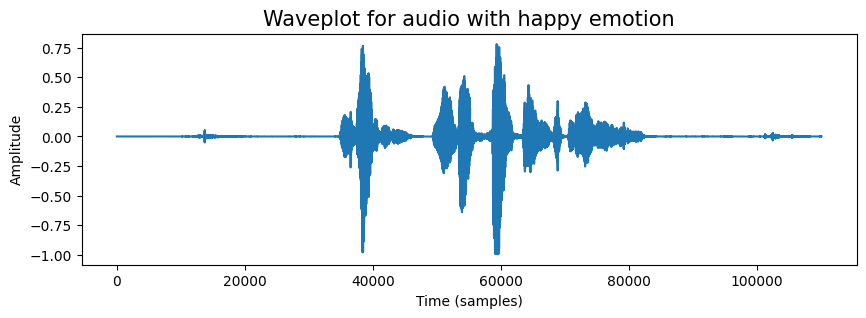

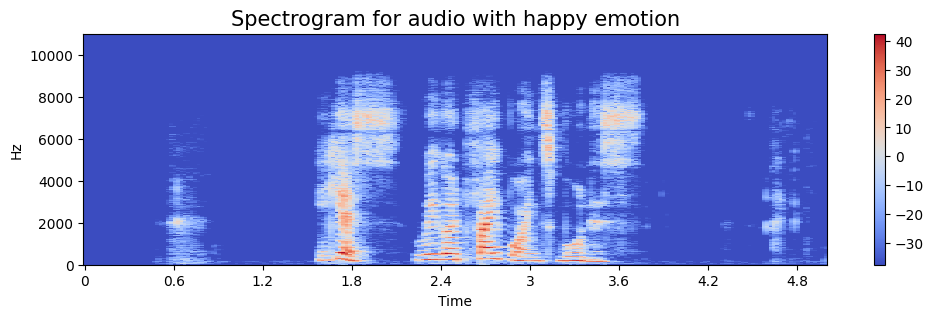

In [260]:
# emotion='happy'
# path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(Happy_Revathi,sr=22050)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(Happy_Revathi)

In [413]:
data, sample_rate = librosa.load(Happy_Revathi, duration=2.5, offset=0.6)
result = np.array([])
zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
result=np.hstack((result, zcr)) # stacking horizontally

# Chroma_stft
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

# MFCC
mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mfcc)) # stacking horizontally

# Root Mean Square Value
rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
result = np.hstack((result, rms)) # stacking horizontally

# MelSpectogram
mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mel)) # stacking horizontally

# Statistics
mean = np.mean(data)#
result=np.hstack((result, mean)) # stacking horizontally

variance = np.var(data)#
result=np.hstack((result, variance)) # stacking horizontally

skewness = scipy.stats.skew(data)#
result=np.hstack((result, skewness)) # stacking horizontally

kurtosis = scipy.stats.kurtosis(data)#
result=np.hstack((result, kurtosis)) # stacking horizontally

audio_rms = librosa.feature.rms(y=data)
audio_rms_mean = audio_rms.mean()#
result=np.hstack((result, audio_rms_mean)) # stacking horizontally

spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sampling_rate)[0]#
result=np.hstack((result, spectral_centroids.mean())) # stacking horizontally

spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sampling_rate)[0]#
result=np.hstack((result, spectral_bandwidth.mean())) # stacking horizontally

mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
mfcc = mfccs.mean()#
result=np.hstack((result, mfcc)) # stacking horizontally



In [414]:
result_reshaped = result.reshape((1, 170))

In [415]:
result_reshaped=np.array(pd.DataFrame(result_reshaped))
X_stat_new=result_reshaped[:,161:169]
X_ac_new=result_reshaped[:,:161]

In [416]:
X_ac_new.shape

(1, 161)

In [417]:
# Array conversion
X_ac_new=np.array(X_ac_new)
X_stat_new=np.array(X_stat_new)
gender_new=np.array([0])

X_ac_new.shape,X_stat_new.shape,gender_new.shape

((1, 161), (1, 8), (1,))

In [418]:
# concatenate
# X_ac_new,
gender_new1 = np.expand_dims(gender_new, axis=1)
gender_new1.shape

(1, 1)

In [419]:

x_new=np.concatenate((X_ac_new,X_stat_new,gender_new1),axis=1)

In [420]:
x_new.shape

(1, 170)

In [421]:
# Acoustic feature segregation for deep feature extraction
x_new_deep = x_new[:, :162]
x_new_stat=x_new[:, 162:170]
x_new_gen=x_new[:,-1]
x_new_gen = np.expand_dims(x_new_gen, axis=1)

In [422]:
x_new_gen.shape,x_new_stat.shape,x_new_deep.shape

((1, 1), (1, 8), (1, 162))

In [423]:
# Normalization
x_new = scaler.transform(x_new)
x_new.shape

(1, 170)

In [424]:
# Acoustic feature segregation for deep feature extraction
x_new_deep = x_new[:, :162]
x_new_stat=x_new[:, 162:170]
x_new_gen=x_new[:,-1]
x_new_gen = np.expand_dims(x_new_gen, axis=1)

In [425]:
x_new_deep.shape,x_new_stat.shape,x_new_gen.shape

((1, 162), (1, 8), (1, 1))

In [426]:
# For compatibility with model
x_new=np.expand_dims(x_new, axis=2)
x_new_deep=np.expand_dims(x_new_deep, axis=2)
x_new_stat=np.expand_dims(x_new_stat, axis=2)

In [427]:
x_new_deep.shape

(1, 162, 1)

In [428]:
conv1d_features_new=conv1d_feature_model.predict(x_new_deep)

1/1 [==============================] - 0s 31ms/step


In [429]:
conv1d_features_new.shape,x_new_stat.shape,x_new_gen.shape

((1, 32), (1, 8, 1), (1, 1))

In [430]:
x_new_stat=x_new_stat.reshape((1,8))

In [431]:
conv1d_features_new.shape,x_new_stat.shape,x_new_gen.shape

((1, 32), (1, 8), (1, 1))

In [432]:
x_new_concat=np.concatenate((conv1d_features_new,x_new_stat,x_new_gen),axis=1)

In [433]:
x_new_concat.shape

(1, 41)

In [227]:
# x_new_combined=np.concatenate((result,np.array([0])),axis=1)

In [85]:
from tensorflow.keras.models import load_model
ser_fusionnet = load_model('ser_fusionnet.h5')

In [283]:
ser_fusionnet.predict(x_new_concat)

<KerasTensor: shape=(None, 41) dtype=float32 (created by layer 'dense_32_input')>

In [434]:
pred=ser_fusionnet.predict(x_new_concat)

1/1 [==============================] - 0s 70ms/step


In [435]:
# predicting on test data.
# pred_test = model_classify.predict(stat_deep_test)
y_pred = encoder.inverse_transform(pred)

# y_test = encoder.inverse_transform(y_test)

In [436]:
y_pred

array([['angry']], dtype='<U7')

###### Sad

In [4]:
Sad_Neetu = '/kaggle/input/neetu-audio/output_layoff.wav'

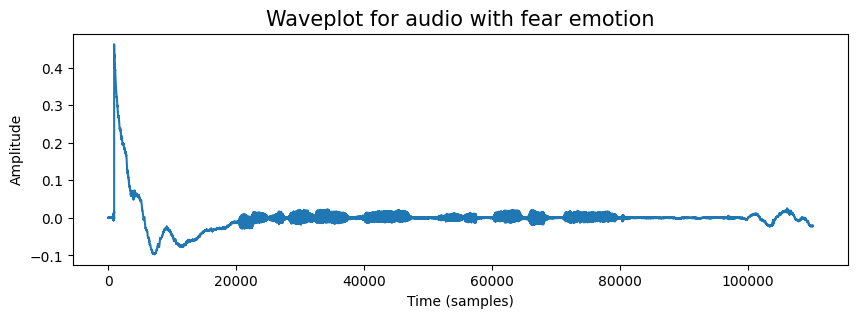

NameError: name 'Happy_Revathi' is not defined

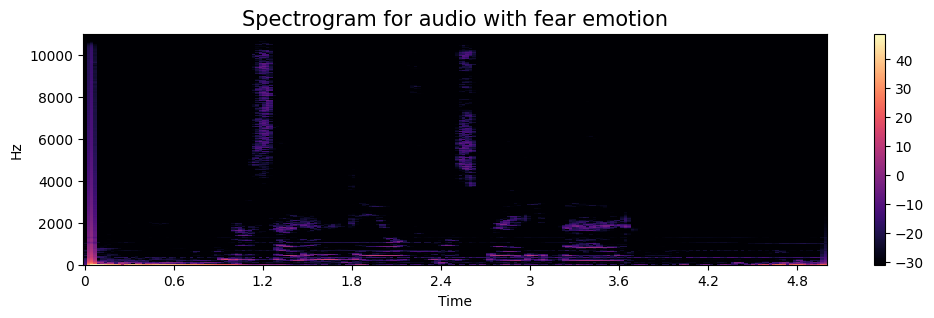

In [79]:
data, sampling_rate = librosa.load(Sad_Neetu,sr=22050)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(Happy_Revathi)

In [93]:
data, sample_rate = librosa.load(Sad_Neetu, duration=2.5, offset=0.6)
result = np.array([])
zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
result=np.hstack((result, zcr)) # stacking horizontally

# Chroma_stft
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

# MFCC
mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mfcc)) # stacking horizontally

# Root Mean Square Value
rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
result = np.hstack((result, rms)) # stacking horizontally

# MelSpectogram
mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mel)) # stacking horizontally

# Statistics
mean = np.mean(data)#
result=np.hstack((result, mean)) # stacking horizontally

variance = np.var(data)#
result=np.hstack((result, variance)) # stacking horizontally

skewness = scipy.stats.skew(data)#
result=np.hstack((result, skewness)) # stacking horizontally

kurtosis = scipy.stats.kurtosis(data)#
result=np.hstack((result, kurtosis)) # stacking horizontally

audio_rms = librosa.feature.rms(y=data)
audio_rms_mean = audio_rms.mean()#
result=np.hstack((result, audio_rms_mean)) # stacking horizontally

spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sampling_rate)[0]#
result=np.hstack((result, spectral_centroids.mean())) # stacking horizontally

spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sampling_rate)[0]#
result=np.hstack((result, spectral_bandwidth.mean())) # stacking horizontally

mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
mfcc = mfccs.mean()#
result=np.hstack((result, mfcc)) # stacking horizontally

In [94]:
result_reshaped = result.reshape((1, 170))
result_reshaped=np.array(pd.DataFrame(result_reshaped))
X_stat_new=result_reshaped[:,161:169]
X_ac_new=result_reshaped[:,:161]

# Array conversion
X_ac_new=np.array(X_ac_new)
X_stat_new=np.array(X_stat_new)
gender_new=np.array([0])

X_ac_new.shape,X_stat_new.shape,gender_new.shape
# concatenate
# X_ac_new,
gender_new1 = np.expand_dims(gender_new, axis=1)
gender_new1.shape


x_new=np.concatenate((X_ac_new,X_stat_new,gender_new1),axis=1)

# Acoustic feature segregation for deep feature extraction
x_new_deep = x_new[:, :162]
x_new_stat=x_new[:, 162:170]
x_new_gen=x_new[:,-1]
x_new_gen = np.expand_dims(x_new_gen, axis=1)

# Normalization
x_new = scaler.transform(x_new)
x_new.shape

# Acoustic feature segregation for deep feature extraction
x_new_deep = x_new[:, :162]
x_new_stat=x_new[:, 162:170]
x_new_gen=x_new[:,-1]
x_new_gen = np.expand_dims(x_new_gen, axis=1)

# For compatibility with model
x_new=np.expand_dims(x_new, axis=2)
x_new_deep=np.expand_dims(x_new_deep, axis=2)
x_new_stat=np.expand_dims(x_new_stat, axis=2)

conv1d_features_new=conv1d_feature_model.predict(x_new_deep)

x_new_stat=x_new_stat.reshape((1,8))

x_new_concat=np.concatenate((conv1d_features_new,x_new_stat,x_new_gen),axis=1)

1/1 [==============================] - 0s 30ms/step


In [95]:
pred=ser_fusionnet.predict(x_new_concat)

1/1 [==============================] - 0s 23ms/step


In [97]:
y_pred = encoder.inverse_transform(pred)

In [99]:
print(f"Neetu is {y_pred[0][0]}!!!")

Neetu is sad!!!


## Real Time Emotion Predictor using SER-FusionNet

In [2]:
import librosa

In [5]:
data, sampling_rate = librosa.load(Sad_Neetu,sr=22050)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(Sad_Neetu)

/tmp/ipykernel_35/3777115869.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sampling_rate = librosa.load(Sad_Neetu,sr=22050)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/neetu-audio/output_layoff.wav'

In [108]:
data, sample_rate = librosa.load(Sad_Neetu, duration=2.5, offset=0.6)
result = np.array([])
zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
result=np.hstack((result, zcr)) # stacking horizontally

# Chroma_stft
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

# MFCC
mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mfcc)) # stacking horizontally

# Root Mean Square Value
rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
result = np.hstack((result, rms)) # stacking horizontally

# MelSpectogram
mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mel)) # stacking horizontally

# Statistics
mean = np.mean(data)#
result=np.hstack((result, mean)) # stacking horizontally

variance = np.var(data)#
result=np.hstack((result, variance)) # stacking horizontally

skewness = scipy.stats.skew(data)#
result=np.hstack((result, skewness)) # stacking horizontally

kurtosis = scipy.stats.kurtosis(data)#
result=np.hstack((result, kurtosis)) # stacking horizontally

audio_rms = librosa.feature.rms(y=data)
audio_rms_mean = audio_rms.mean()#
result=np.hstack((result, audio_rms_mean)) # stacking horizontally

spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sampling_rate)[0]#
result=np.hstack((result, spectral_centroids.mean())) # stacking horizontally

spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sampling_rate)[0]#
result=np.hstack((result, spectral_bandwidth.mean())) # stacking horizontally

mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
mfcc = mfccs.mean()#
result=np.hstack((result, mfcc)) # stacking horizontally

result_reshaped = result.reshape((1, 170))
result_reshaped=np.array(pd.DataFrame(result_reshaped))
X_stat_new=result_reshaped[:,161:169]
X_ac_new=result_reshaped[:,:161]

# Array conversion
X_ac_new=np.array(X_ac_new)
X_stat_new=np.array(X_stat_new)
gender_new=np.array([0])

X_ac_new.shape,X_stat_new.shape,gender_new.shape
# concatenate
# X_ac_new,
gender_new1 = np.expand_dims(gender_new, axis=1)
gender_new1.shape


x_new=np.concatenate((X_ac_new,X_stat_new,gender_new1),axis=1)

# Acoustic feature segregation for deep feature extraction
x_new_deep = x_new[:, :162]
x_new_stat=x_new[:, 162:170]
x_new_gen=x_new[:,-1]
x_new_gen = np.expand_dims(x_new_gen, axis=1)

# Normalization
x_new = scaler.transform(x_new)
x_new.shape

# Acoustic feature segregation for deep feature extraction
x_new_deep = x_new[:, :162]
x_new_stat=x_new[:, 162:170]
x_new_gen=x_new[:,-1]
x_new_gen = np.expand_dims(x_new_gen, axis=1)

# For compatibility with model
x_new=np.expand_dims(x_new, axis=2)
x_new_deep=np.expand_dims(x_new_deep, axis=2)
x_new_stat=np.expand_dims(x_new_stat, axis=2)

conv1d_features_new=conv1d_feature_model.predict(x_new_deep)

x_new_stat=x_new_stat.reshape((1,8))

x_new_concat=np.concatenate((conv1d_features_new,x_new_stat,x_new_gen),axis=1)

1/1 [==============================] - 0s 38ms/step


In [109]:
pred=ser_fusionnet.predict(x_new_concat)
y_pred = encoder.inverse_transform(pred)

print(f"Neetu is {y_pred[0][0]}!!!")

1/1 [==============================] - 0s 23ms/step

Neetu is sad!!!


In [ ]:
data, sampling_rate = librosa.load(Sad_Neetu,sr=22050)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(Sad_Neetu)

In [ ]:
data, sample_rate = librosa.load(Sad_Neetu, duration=2.5, offset=0.6)
result = np.array([])
zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
result=np.hstack((result, zcr)) # stacking horizontally

# Chroma_stft
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

# MFCC
mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mfcc)) # stacking horizontally

# Root Mean Square Value
rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
result = np.hstack((result, rms)) # stacking horizontally

# MelSpectogram
mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mel)) # stacking horizontally

# Statistics
mean = np.mean(data)#
result=np.hstack((result, mean)) # stacking horizontally

variance = np.var(data)#
result=np.hstack((result, variance)) # stacking horizontally

skewness = scipy.stats.skew(data)#
result=np.hstack((result, skewness)) # stacking horizontally

kurtosis = scipy.stats.kurtosis(data)#
result=np.hstack((result, kurtosis)) # stacking horizontally

audio_rms = librosa.feature.rms(y=data)
audio_rms_mean = audio_rms.mean()#
result=np.hstack((result, audio_rms_mean)) # stacking horizontally

spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sampling_rate)[0]#
result=np.hstack((result, spectral_centroids.mean())) # stacking horizontally

spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sampling_rate)[0]#
result=np.hstack((result, spectral_bandwidth.mean())) # stacking horizontally

mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
mfcc = mfccs.mean()#
result=np.hstack((result, mfcc)) # stacking horizontally

result_reshaped = result.reshape((1, 170))
result_reshaped=np.array(pd.DataFrame(result_reshaped))
X_stat_new=result_reshaped[:,161:169]
X_ac_new=result_reshaped[:,:161]

# Array conversion
X_ac_new=np.array(X_ac_new)
X_stat_new=np.array(X_stat_new)
gender_new=np.array([0])

X_ac_new.shape,X_stat_new.shape,gender_new.shape
# concatenate
# X_ac_new,
gender_new1 = np.expand_dims(gender_new, axis=1)
gender_new1.shape


x_new=np.concatenate((X_ac_new,X_stat_new,gender_new1),axis=1)

# Acoustic feature segregation for deep feature extraction
x_new_deep = x_new[:, :162]
x_new_stat=x_new[:, 162:170]
x_new_gen=x_new[:,-1]
x_new_gen = np.expand_dims(x_new_gen, axis=1)

# Normalization
x_new = scaler.transform(x_new)
x_new.shape

# Acoustic feature segregation for deep feature extraction
x_new_deep = x_new[:, :162]
x_new_stat=x_new[:, 162:170]
x_new_gen=x_new[:,-1]
x_new_gen = np.expand_dims(x_new_gen, axis=1)

# For compatibility with model
x_new=np.expand_dims(x_new, axis=2)
x_new_deep=np.expand_dims(x_new_deep, axis=2)
x_new_stat=np.expand_dims(x_new_stat, axis=2)

conv1d_features_new=conv1d_feature_model.predict(x_new_deep)

x_new_stat=x_new_stat.reshape((1,8))

x_new_concat=np.concatenate((conv1d_features_new,x_new_stat,x_new_gen),axis=1)